# 变量解释

Pregnancies: 怀孕次数

Glucose：葡萄糖  正常为3.92-6.16$mmol/L$

BloodPressure;血压（$mm Hg$）正常范围90-140

SkinThickness：皮脂厚度($mm$)超过20即为肥胖

Insulin：2小时血清胰岛素含量（$mu/ml$）正常人为4.03-23.46

BMI： 体重指数($kg/m^2$) BMI大于28即为肥胖

DiabetesPedigreeFunction： 遗传指数

Age; 年龄(岁）

Outcome: 标签 1：患病 0： 不患病

In [317]:
import pandas as pd
pd.set_option('precision', 3)   # 设置精度
import numpy as np
from sklearn import metrics
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
from matplotlib import font_manager
plt.rcParams['font.sans-serif'] = ['SimHei']   # 中文显示问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from sklearn.metrics import accuracy_score  # 准确率
import warnings

warnings.filterwarnings("ignore")

In [352]:
diabetes = pd.read_csv("D:/deep-learning/datasets/diabetes.csv")
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 标签频数观察

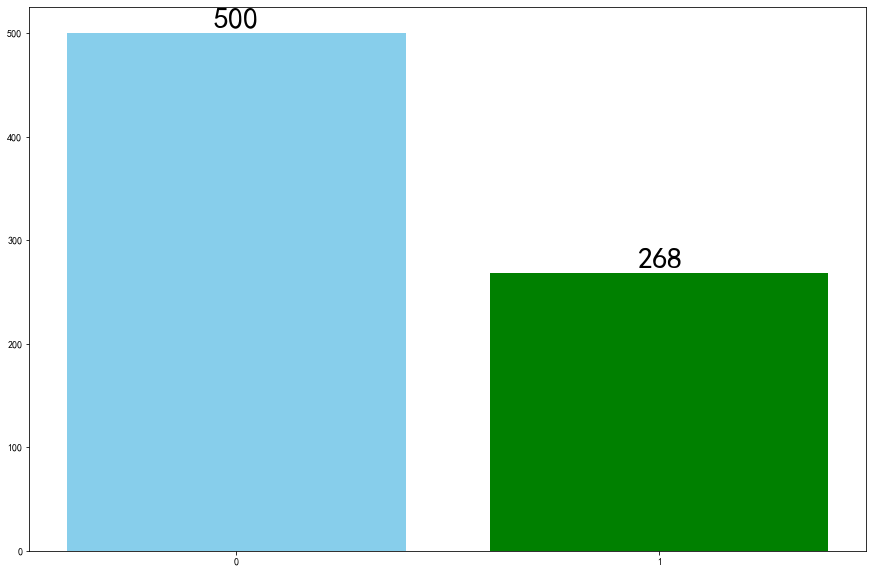

In [288]:
plt.figure(figsize = (15, 10))
label_counts = diabetes['Outcome'].value_counts()   # 统计标签频数
plt.bar(label_counts.keys(), label_counts.values, color = ['skyblue', 'g'])
plt.xticks(label_counts.keys())
for a, b in zip(label_counts.keys(), label_counts.values):
    plt.text(a, b, '%.0f'%b, ha = 'center', va = 'bottom', fontsize =30)
plt.show()

# 处理数据
## 异常值处理

In [289]:
diabetes.describe()    # 查看数据均值、标准差、最大、最小值、分位数

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


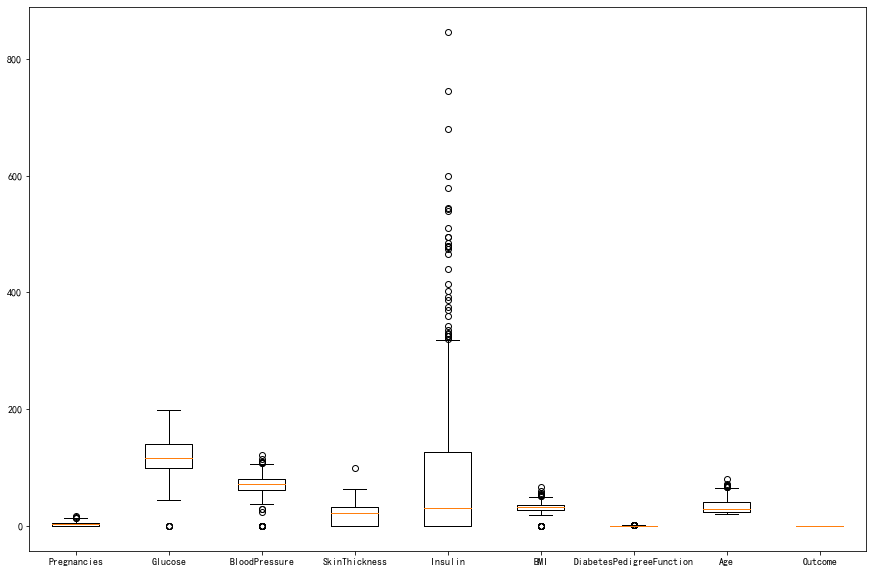

In [290]:
'''通过箱线图观察'''
plt.figure(figsize = (15, 10))
plt.boxplot(diabetes, labels = diabetes.columns)
plt.show()

3$\sigma$原则适用于服从正态分布的数据

箱线图异常值定义为小于$Q_1 - 1.5IQR$或大于$Q_3 + 1.5IQR$  $IQR = Q_3 - Q_1$

而考虑数据信息的丢失，只删除一些明显异常的值：Insulin = 846、skinthickness = 99、 BMI = 67

而怀孕次数、血压、年龄的取值是在合理范围之内，不做异常值处理。

In [353]:
'''处理异常值'''
diabetes = diabetes.loc[~diabetes['Insulin'].isin([846])]
diabetes = diabetes.loc[~diabetes['SkinThickness'].isin([99])]
diabetes = diabetes.loc[~diabetes['BMI'].isin([67.1])]
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 缺失值处理

2小时血清胰岛素含量、葡萄糖含量、血压、皮脂厚度为0十分反常，可以认为是存在缺失值的。

以同类平均数进行填充

In [354]:
diabetes_0 = diabetes.loc[diabetes['Outcome'] == 0]
diabetes_1 = diabetes.loc[diabetes['Outcome'] == 1]
zero_mean = diabetes_0.mean()
one_mean = diabetes_1.mean()
zero_mean, one_mean

(Pregnancies                   3.298
 Glucose                     109.980
 BloodPressure                68.184
 SkinThickness                19.664
 Insulin                      68.792
 BMI                          30.304
 DiabetesPedigreeFunction      0.430
 Age                          31.190
 Outcome                       0.000
 dtype: float64,
 Pregnancies                   4.909
 Glucose                     140.913
 BloodPressure                70.721
 SkinThickness                21.781
 Insulin                      97.789
 BMI                          35.043
 DiabetesPedigreeFunction      0.552
 Age                          36.932
 Outcome                       1.000
 dtype: float64)

In [355]:
for attribute in ['Insulin', 'Glucose', 'BloodPressure', 'SkinThickness']:
    for i in diabetes.index:
        if diabetes[attribute][i] == 0:
            if diabetes['Outcome'][i] == 0:
                diabetes[attribute][i] = zero_mean[attribute]
            else:
                diabetes[attribute][i] = one_mean[attribute] 
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,97,33.6,0.627,50,1
1,1,85,66,29,68,26.6,0.351,31,0
2,8,183,64,21,97,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,68,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,21,97,30.1,0.349,47,1


# 确认处理后数据

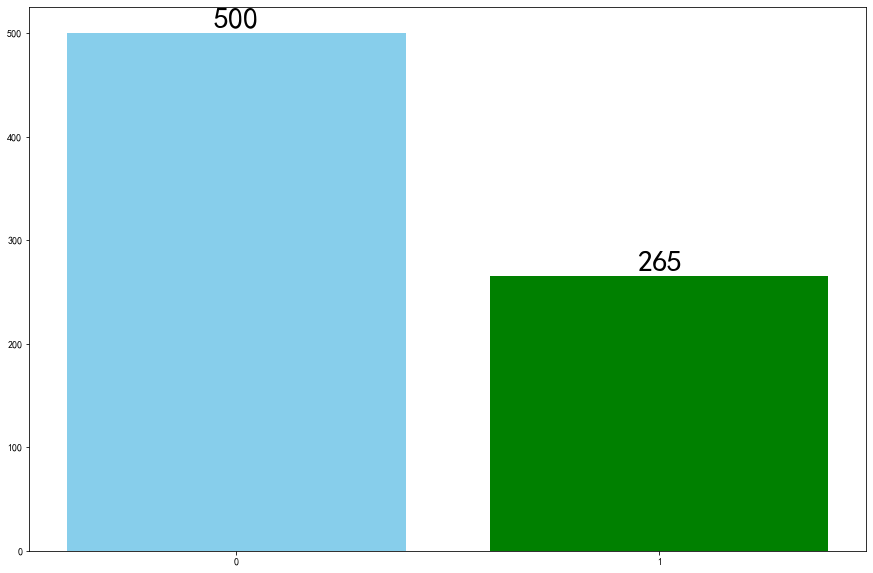

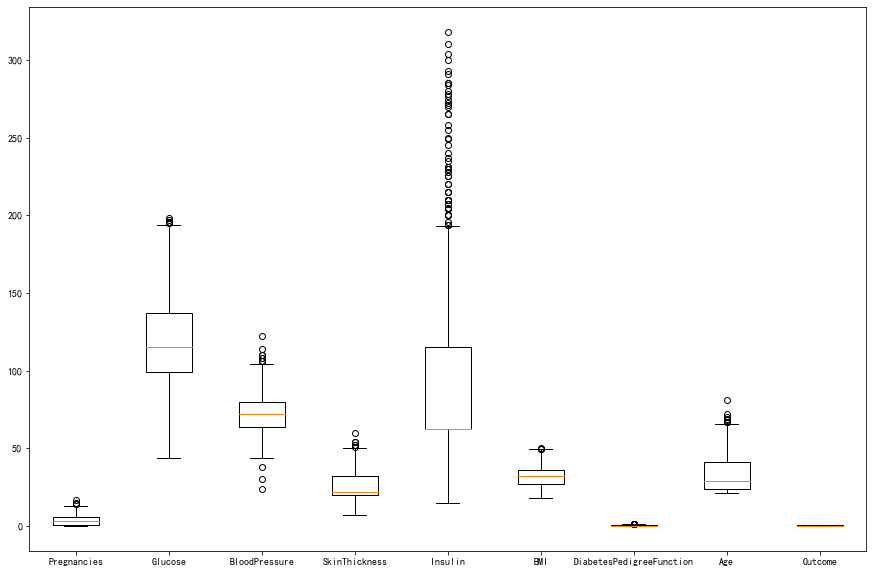

In [356]:
plt.figure(figsize = (15, 10))
label_counts = diabetes['Outcome'].value_counts()   # 统计标签频数
plt.bar(label_counts.keys(), label_counts.values, color = ['skyblue', 'g'])
plt.xticks(label_counts.keys())
for a, b in zip(label_counts.keys(), label_counts.values):
    plt.text(a, b, '%.0f'%b, ha = 'center', va = 'bottom', fontsize =30)
plt.show()
plt.figure(figsize = (15, 10))
plt.boxplot(dia_norm, labels = dia_norm.columns)
plt.show()

In [357]:
X = diabetes.iloc[:,:-1]
Y = diabetes.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123457)

In [358]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# KNN

In [359]:
from sklearn.neighbors import KNeighborsClassifier
avg_scores = []
all_scores = []
test_scores = []
parameter_value = list(range(1, 21))
for n_neighbors in parameter_value:
    KNN = KNeighborsClassifier(n_neighbors = n_neighbors)
    scores = cross_val_score(KNN, X_train, y_train, scoring = 'accuracy')
    KNN.fit(X_train, y_train)
    y_pre = KNN.predict(X_test)
    KNN_accuracy = accuracy_score(y_test,y_pre)
    avg_scores.append(np.mean(scores))
    all_scores.append(scores)
    test_scores.append(KNN_accuracy)

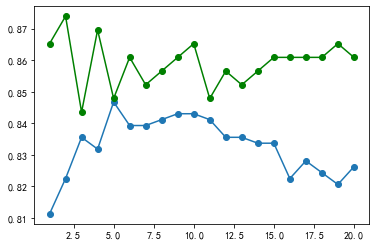

In [360]:
plt.plot(parameter_value, avg_scores, '-o')
plt.plot(parameter_value, test_scores, '-o', color = 'g')
plt.show()

In [361]:
# k = 5
KNN = KNeighborsClassifier(n_neighbors = 7)
KNN.fit(X_train, y_train)
y_pre = KNN.predict(X_test)
KNN_accuracy = accuracy_score(y_test,y_pre)
print(f'测试集准确率为：{KNN_accuracy:.4f}')

测试集准确率为：0.8522


# 随机森林

In [362]:
from sklearn.ensemble import RandomForestClassifier
parameter_space = {
    'max_features': [2, 10, 'auto'],
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6]
}
clf = RandomForestClassifier(random_state = 3)
grid_rt = GridSearchCV(clf, parameter_space)
grid_rt.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=3),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [2, 10, 'auto'],
                         'min_samples_leaf': [2, 4, 6],
                         'n_estimators': [100, 200]})

In [363]:
print(grid_rt.best_score_)
print(grid_rt.best_estimator_)

0.8803738317757009
RandomForestClassifier(criterion='entropy', max_features=2, min_samples_leaf=4,
                       n_estimators=200, random_state=3)


In [364]:
y_pre = grid_rt.predict(X_test)
RT_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率为：{RT_accuracy:.4f}')

测试集准确率为：0.8870


# catboost

In [365]:
import catboost as cb

cv_parameter = {'iterations': [100, 200]}
parameter_space = {
    'loss_function': 'Logloss',
    'learning_rate': 0.2,
    'depth': 3,
    'leaf_estimation_method': 'Newton',
    'random_state': 12
}
cb_model = cb.CatBoostClassifier(parameter_space)
grid_cb = GridSearchCV(cb_model, cv_parameter)
grid_cb.fit(X_train, y_train)

Learning rate set to 0.059233
0:	learn: 0.6706355	total: 1.77ms	remaining: 175ms
1:	learn: 0.6486420	total: 3.21ms	remaining: 157ms
2:	learn: 0.6284310	total: 4.61ms	remaining: 149ms
3:	learn: 0.6068820	total: 5.99ms	remaining: 144ms
4:	learn: 0.5904740	total: 8.15ms	remaining: 155ms
5:	learn: 0.5741846	total: 9.68ms	remaining: 152ms
6:	learn: 0.5537525	total: 11ms	remaining: 146ms
7:	learn: 0.5362921	total: 12.5ms	remaining: 144ms
8:	learn: 0.5196349	total: 14ms	remaining: 142ms
9:	learn: 0.5081083	total: 15.5ms	remaining: 140ms
10:	learn: 0.4955694	total: 16.9ms	remaining: 136ms
11:	learn: 0.4852752	total: 18.3ms	remaining: 134ms
12:	learn: 0.4751985	total: 19.7ms	remaining: 132ms
13:	learn: 0.4650801	total: 21.4ms	remaining: 131ms
14:	learn: 0.4541168	total: 23.1ms	remaining: 131ms
15:	learn: 0.4456491	total: 24.5ms	remaining: 129ms
16:	learn: 0.4359000	total: 25.8ms	remaining: 126ms
17:	learn: 0.4252160	total: 27.2ms	remaining: 124ms
18:	learn: 0.4188805	total: 28.6ms	remaining: 12

Learning rate set to 0.059233
0:	learn: 0.6718876	total: 1.98ms	remaining: 196ms
1:	learn: 0.6474830	total: 3.39ms	remaining: 166ms
2:	learn: 0.6281376	total: 4.88ms	remaining: 158ms
3:	learn: 0.6032154	total: 6.21ms	remaining: 149ms
4:	learn: 0.5868079	total: 7.6ms	remaining: 144ms
5:	learn: 0.5708675	total: 8.96ms	remaining: 140ms
6:	learn: 0.5545163	total: 10.4ms	remaining: 138ms
7:	learn: 0.5400751	total: 11.8ms	remaining: 136ms
8:	learn: 0.5246564	total: 13.4ms	remaining: 135ms
9:	learn: 0.5126017	total: 14.8ms	remaining: 133ms
10:	learn: 0.5002890	total: 16.3ms	remaining: 132ms
11:	learn: 0.4890281	total: 17.7ms	remaining: 130ms
12:	learn: 0.4802411	total: 19.8ms	remaining: 132ms
13:	learn: 0.4678206	total: 21.1ms	remaining: 130ms
14:	learn: 0.4564943	total: 22.6ms	remaining: 128ms
15:	learn: 0.4465586	total: 24ms	remaining: 126ms
16:	learn: 0.4347953	total: 25.4ms	remaining: 124ms
17:	learn: 0.4245873	total: 27.5ms	remaining: 125ms
18:	learn: 0.4180391	total: 29.1ms	remaining: 1

Learning rate set to 0.059233
0:	learn: 0.6722593	total: 1.71ms	remaining: 169ms
1:	learn: 0.6482938	total: 3.12ms	remaining: 153ms
2:	learn: 0.6311119	total: 4.5ms	remaining: 145ms
3:	learn: 0.6079939	total: 5.71ms	remaining: 137ms
4:	learn: 0.5898977	total: 7.42ms	remaining: 141ms
5:	learn: 0.5724643	total: 9.2ms	remaining: 144ms
6:	learn: 0.5570918	total: 10.6ms	remaining: 140ms
7:	learn: 0.5434982	total: 12ms	remaining: 138ms
8:	learn: 0.5275583	total: 13.4ms	remaining: 135ms
9:	learn: 0.5158513	total: 14.7ms	remaining: 132ms
10:	learn: 0.5028573	total: 16.1ms	remaining: 130ms
11:	learn: 0.4928038	total: 17.5ms	remaining: 128ms
12:	learn: 0.4825031	total: 18.9ms	remaining: 126ms
13:	learn: 0.4748520	total: 20.5ms	remaining: 126ms
14:	learn: 0.4639312	total: 22.8ms	remaining: 129ms
15:	learn: 0.4536456	total: 24.4ms	remaining: 128ms
16:	learn: 0.4451830	total: 25.8ms	remaining: 126ms
17:	learn: 0.4349881	total: 27.3ms	remaining: 124ms
18:	learn: 0.4264455	total: 28.7ms	remaining: 12

85:	learn: 0.1718870	total: 161ms	remaining: 214ms
86:	learn: 0.1696640	total: 163ms	remaining: 212ms
87:	learn: 0.1686449	total: 165ms	remaining: 209ms
88:	learn: 0.1668203	total: 167ms	remaining: 208ms
89:	learn: 0.1659484	total: 168ms	remaining: 206ms
90:	learn: 0.1650975	total: 170ms	remaining: 204ms
91:	learn: 0.1641879	total: 172ms	remaining: 202ms
92:	learn: 0.1633313	total: 174ms	remaining: 200ms
93:	learn: 0.1616843	total: 175ms	remaining: 198ms
94:	learn: 0.1610058	total: 177ms	remaining: 196ms
95:	learn: 0.1599650	total: 179ms	remaining: 194ms
96:	learn: 0.1592445	total: 182ms	remaining: 193ms
97:	learn: 0.1580047	total: 184ms	remaining: 191ms
98:	learn: 0.1576753	total: 186ms	remaining: 190ms
99:	learn: 0.1564165	total: 189ms	remaining: 189ms
100:	learn: 0.1549402	total: 190ms	remaining: 187ms
101:	learn: 0.1540365	total: 192ms	remaining: 185ms
102:	learn: 0.1534085	total: 194ms	remaining: 183ms
103:	learn: 0.1528557	total: 196ms	remaining: 181ms
104:	learn: 0.1515459	total

68:	learn: 0.2036534	total: 145ms	remaining: 276ms
69:	learn: 0.2027298	total: 148ms	remaining: 275ms
70:	learn: 0.2017480	total: 151ms	remaining: 275ms
71:	learn: 0.2004669	total: 153ms	remaining: 272ms
72:	learn: 0.1985873	total: 154ms	remaining: 268ms
73:	learn: 0.1977217	total: 156ms	remaining: 266ms
74:	learn: 0.1966196	total: 158ms	remaining: 263ms
75:	learn: 0.1951227	total: 160ms	remaining: 260ms
76:	learn: 0.1924877	total: 162ms	remaining: 259ms
77:	learn: 0.1919992	total: 163ms	remaining: 256ms
78:	learn: 0.1906694	total: 165ms	remaining: 253ms
79:	learn: 0.1896203	total: 168ms	remaining: 251ms
80:	learn: 0.1883815	total: 170ms	remaining: 250ms
81:	learn: 0.1869988	total: 173ms	remaining: 249ms
82:	learn: 0.1860294	total: 175ms	remaining: 247ms
83:	learn: 0.1842999	total: 177ms	remaining: 245ms
84:	learn: 0.1830708	total: 180ms	remaining: 243ms
85:	learn: 0.1824747	total: 182ms	remaining: 241ms
86:	learn: 0.1813415	total: 184ms	remaining: 239ms
87:	learn: 0.1798560	total: 187

85:	learn: 0.1752930	total: 160ms	remaining: 213ms
86:	learn: 0.1743425	total: 162ms	remaining: 211ms
87:	learn: 0.1730578	total: 164ms	remaining: 209ms
88:	learn: 0.1717959	total: 166ms	remaining: 207ms
89:	learn: 0.1705268	total: 167ms	remaining: 204ms
90:	learn: 0.1692844	total: 169ms	remaining: 202ms
91:	learn: 0.1685813	total: 171ms	remaining: 200ms
92:	learn: 0.1681114	total: 172ms	remaining: 198ms
93:	learn: 0.1663895	total: 175ms	remaining: 197ms
94:	learn: 0.1657411	total: 177ms	remaining: 196ms
95:	learn: 0.1645771	total: 179ms	remaining: 194ms
96:	learn: 0.1635988	total: 181ms	remaining: 192ms
97:	learn: 0.1626468	total: 182ms	remaining: 190ms
98:	learn: 0.1623391	total: 184ms	remaining: 188ms
99:	learn: 0.1609039	total: 186ms	remaining: 186ms
100:	learn: 0.1595721	total: 188ms	remaining: 184ms
101:	learn: 0.1586585	total: 189ms	remaining: 182ms
102:	learn: 0.1580203	total: 191ms	remaining: 180ms
103:	learn: 0.1569091	total: 193ms	remaining: 178ms
104:	learn: 0.1552336	total

80:	learn: 0.1710947	total: 159ms	remaining: 234ms
81:	learn: 0.1702008	total: 161ms	remaining: 232ms
82:	learn: 0.1692740	total: 163ms	remaining: 229ms
83:	learn: 0.1679070	total: 164ms	remaining: 227ms
84:	learn: 0.1665510	total: 166ms	remaining: 225ms
85:	learn: 0.1656283	total: 168ms	remaining: 223ms
86:	learn: 0.1646930	total: 170ms	remaining: 220ms
87:	learn: 0.1638992	total: 171ms	remaining: 218ms
88:	learn: 0.1632551	total: 174ms	remaining: 216ms
89:	learn: 0.1609924	total: 175ms	remaining: 214ms
90:	learn: 0.1603109	total: 177ms	remaining: 212ms
91:	learn: 0.1597405	total: 180ms	remaining: 211ms
92:	learn: 0.1591542	total: 182ms	remaining: 209ms
93:	learn: 0.1578828	total: 184ms	remaining: 207ms
94:	learn: 0.1566059	total: 185ms	remaining: 205ms
95:	learn: 0.1553478	total: 187ms	remaining: 203ms
96:	learn: 0.1547280	total: 189ms	remaining: 201ms
97:	learn: 0.1542467	total: 191ms	remaining: 199ms
98:	learn: 0.1537616	total: 193ms	remaining: 197ms
99:	learn: 0.1523756	total: 195

87:	learn: 0.1722638	total: 165ms	remaining: 210ms
88:	learn: 0.1715637	total: 167ms	remaining: 208ms
89:	learn: 0.1706474	total: 169ms	remaining: 206ms
90:	learn: 0.1693518	total: 170ms	remaining: 204ms
91:	learn: 0.1682480	total: 172ms	remaining: 202ms
92:	learn: 0.1675620	total: 174ms	remaining: 200ms
93:	learn: 0.1664808	total: 177ms	remaining: 199ms
94:	learn: 0.1655865	total: 178ms	remaining: 197ms
95:	learn: 0.1647343	total: 180ms	remaining: 195ms
96:	learn: 0.1629151	total: 183ms	remaining: 194ms
97:	learn: 0.1620457	total: 184ms	remaining: 192ms
98:	learn: 0.1612395	total: 186ms	remaining: 190ms
99:	learn: 0.1605150	total: 188ms	remaining: 188ms
100:	learn: 0.1593833	total: 190ms	remaining: 186ms
101:	learn: 0.1582712	total: 192ms	remaining: 184ms
102:	learn: 0.1576146	total: 193ms	remaining: 182ms
103:	learn: 0.1567776	total: 195ms	remaining: 180ms
104:	learn: 0.1559657	total: 196ms	remaining: 178ms
105:	learn: 0.1552151	total: 198ms	remaining: 176ms
106:	learn: 0.1546566	tot

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000002610E78F220>,
             param_grid={'iterations': [100, 200]})

In [366]:
print(grid_cb.best_score_)
print(grid_cb.best_estimator_)

0.8710280373831776


In [367]:
y_pre = grid_cb.predict(X_test)
cb_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率;{cb_accuracy:.4f}')

测试集准确率;0.8957


# SVM

In [368]:
from sklearn.svm import SVC

parameters = {'kernel':('linear', 'rbf'), 'C': [1, 10]}
svr = SVC()
grid_svc = GridSearchCV(svr, parameters)
grid_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [369]:
print(grid_svc.best_score_)
print(grid_svc.best_estimator_)

0.8242990654205608
SVC(C=10)


In [370]:
y_pre = grid_svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率：{svc_accuracy:.4f}')

测试集准确率：0.8609


# voting

In [371]:
from mlxtend.classifier import EnsembleVoteClassifier

KNN = KNeighborsClassifier(n_neighbors = 7)
clf = RandomForestClassifier(criterion='entropy', max_features=2, min_samples_leaf=6,
                       n_estimators=200, random_state=3)
svr = SVC(C=10, kernel='linear', probability = True)
eclf = EnsembleVoteClassifier(clfs = [KNN, clf, svr], weights = [1, 2, 2], voting = 'soft')
eclf.fit(X_train, y_train)

EnsembleVoteClassifier(clfs=[KNeighborsClassifier(n_neighbors=7),
                             RandomForestClassifier(criterion='entropy',
                                                    max_features=2,
                                                    min_samples_leaf=6,
                                                    n_estimators=200,
                                                    random_state=3),
                             SVC(C=10, kernel='linear', probability=True)],
                       voting='soft', weights=[1, 2, 2])

In [372]:
y_pre = eclf.predict(X_test)
es_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率:{es_accuracy:.4f}')

测试集准确率:0.8783
